<a href="https://colab.research.google.com/github/Remonah-3/Github_Assignment/blob/master/SimpleConv2d.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np

# Conv2d Layer

class Conv2d:
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0):
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_h, self.kernel_w = kernel_size if isinstance(kernel_size, tuple) else (kernel_size, kernel_size)
        self.stride = stride
        self.padding = padding
        self.W = np.random.randn(self.kernel_h, self.kernel_w, in_channels, out_channels).astype(np.float64) * 0.1
        self.b = np.zeros(out_channels, dtype=np.float64)

    def forward(self, x):
        self.x = x.astype(np.float64)
        n_samples, h_in, w_in, _ = x.shape
        h_out = (h_in + 2*self.padding - self.kernel_h)//self.stride + 1
        w_out = (w_in + 2*self.padding - self.kernel_w)//self.stride + 1
        out = np.zeros((n_samples, h_out, w_out, self.out_channels), dtype=np.float64)

        x_padded = np.pad(self.x, ((0,0), (self.padding,self.padding), (self.padding,self.padding), (0,0)), 'constant') if self.padding>0 else self.x

        for n in range(n_samples):
            for i in range(h_out):
                for j in range(w_out):
                    for m in range(self.out_channels):
                        region = x_padded[n,
                                          i*self.stride:i*self.stride+self.kernel_h,
                                          j*self.stride:j*self.stride+self.kernel_w,
                                          :]
                        out[n,i,j,m] = np.sum(region * self.W[:,:,:,m]) + self.b[m]
        return out

    def backward(self, d_out, learning_rate):
        n_samples, h_in, w_in, _ = self.x.shape
        x_padded = np.pad(self.x, ((0,0), (self.padding,self.padding), (self.padding,self.padding), (0,0)), 'constant') if self.padding>0 else self.x
        dx = np.zeros_like(x_padded, dtype=np.float64)
        dW = np.zeros_like(self.W, dtype=np.float64)
        db = np.zeros_like(self.b, dtype=np.float64)
        h_out, w_out = d_out.shape[1:3]

        for n in range(n_samples):
            for i in range(h_out):
                for j in range(w_out):
                    for m in range(self.out_channels):
                        region = x_padded[n,
                                          i*self.stride:i*self.stride+self.kernel_h,
                                          j*self.stride:j*self.stride+self.kernel_w,
                                          :]
                        dW[:,:,:,m] += region * d_out[n,i,j,m]
                        dx[n,
                           i*self.stride:i*self.stride+self.kernel_h,
                           j*self.stride:j*self.stride+self.kernel_w,
                           :] += self.W[:,:,:,m] * d_out[n,i,j,m]
                        db[m] += d_out[n,i,j,m]

        if self.padding > 0:
            dx = dx[:, self.padding:-self.padding, self.padding:-self.padding, :]

        self.W -= learning_rate * dW
        self.b -= learning_rate * db

        return dx

# MaxPool2D Layer

class MaxPool2D:
    def __init__(self, pool_size=2, stride=2):
        self.pool_h, self.pool_w = pool_size if isinstance(pool_size, tuple) else (pool_size, pool_size)
        self.stride = stride

    def forward(self, x):
        self.x = x.astype(np.float64)
        n_samples, h_in, w_in, c = x.shape
        h_out = (h_in - self.pool_h)//self.stride + 1
        w_out = (w_in - self.pool_w)//self.stride + 1
        out = np.zeros((n_samples, h_out, w_out, c), dtype=np.float64)
        self.max_idx = {}

        for n in range(n_samples):
            for i in range(h_out):
                for j in range(w_out):
                    for k in range(c):
                        region = self.x[n,
                                        i*self.stride:i*self.stride+self.pool_h,
                                        j*self.stride:j*self.stride+self.pool_w,
                                        k]
                        out[n,i,j,k] = np.max(region)
                        self.max_idx[(n,i,j,k)] = np.unravel_index(np.argmax(region), region.shape)
        return out

    def backward(self, d_out):
        n_samples, h_in, w_in, c = self.x.shape
        dx = np.zeros_like(self.x, dtype=np.float64)
        h_out, w_out = d_out.shape[1:3]

        for n in range(n_samples):
            for i in range(h_out):
                for j in range(w_out):
                    for k in range(c):
                        p,q = self.max_idx[(n,i,j,k)]
                        dx[n, i*self.stride + p, j*self.stride + q, k] = d_out[n,i,j,k]
        return dx

# AveragePool2D Layer

class AveragePool2D:
    def __init__(self, pool_size=2, stride=2):
        self.pool_h, self.pool_w = pool_size if isinstance(pool_size, tuple) else (pool_size, pool_size)
        self.stride = stride

    def forward(self, x):
        self.x = x.astype(np.float64)
        n_samples, h_in, w_in, c = x.shape
        h_out = (h_in - self.pool_h)//self.stride + 1
        w_out = (w_in - self.pool_w)//self.stride + 1
        out = np.zeros((n_samples, h_out, w_out, c), dtype=np.float64)

        for n in range(n_samples):
            for i in range(h_out):
                for j in range(w_out):
                    for k in range(c):
                        region = self.x[n,
                                        i*self.stride:i*self.stride+self.pool_h,
                                        j*self.stride:j*self.stride+self.pool_w,
                                        k]
                        out[n,i,j,k] = np.mean(region)
        return out

    def backward(self, d_out):
        n_samples, h_in, w_in, c = self.x.shape
        dx = np.zeros_like(self.x, dtype=np.float64)
        h_out, w_out = d_out.shape[1:3]
        for n in range(n_samples):
            for i in range(h_out):
                for j in range(w_out):
                    for k in range(c):
                        dx[n,
                           i*self.stride:i*self.stride+self.pool_h,
                           j*self.stride:j*self.stride+self.pool_w,
                           k] = d_out[n,i,j,k] / (self.pool_h*self.pool_w)
        return dx

# Flatten Layer

class Flatten:
    def forward(self, x):
        self.original_shape = x.shape
        return x.reshape(x.shape[0], -1)

    def backward(self, d_out):
        return d_out.reshape(self.original_shape)

# Forward & Backward Test Example

if __name__ == "__main__":
    # Input as float64
    x = np.array([[[[ 1], [ 2], [ 3], [ 4]],
                   [[ 5], [ 6], [ 7], [ 8]],
                   [[ 9], [10], [11], [12]],
                   [[13], [14], [15], [16]]]], dtype=np.float64)

    w = np.array([[[[ 0.,  0.]],
                   [[ 0.,  0.]],
                   [[ 0.,  0.]]],

                  [[[ 0.,  0.]],
                   [[ 1., -1.]],
                   [[ 0.,  1.]]],

                  [[[ 0.,  0.]],
                   [[-1.,  0.]],
                   [[ 0.,  0.]]]], dtype=np.float64)

    b = np.array([0., 0.], dtype=np.float64)

    conv = Conv2d(in_channels=1, out_channels=2, kernel_size=3)
    conv.W = w
    conv.b = b

    out = conv.forward(x)
    print("Conv Forward Output:\n", out[0,:,:,0], "\n", out[0,:,:,1])

    delta = np.array([[[[-4,  1],
                        [-4, -7]],
                       [[10,  1],
                        [11, -11]]]], dtype=np.float64)
    dx = conv.backward(delta, learning_rate=0.01)
    print("Conv Backward dx:\n", dx[0,:,:,0])


Conv Forward Output:
 [[-4. -4.]
 [-4. -4.]] 
 [[1. 1.]
 [1. 1.]]
Conv Backward dx:
 [[  0.   0.   0.   0.]
 [  0.  -5.   4.  -7.]
 [  0.  13.  27. -11.]
 [  0. -10. -11.   0.]]


## Problem 9: CNN models

There are several famous CNN models used in image recognition.

AlexNet, created in 2012, was the first deep CNN to win a big image competition called ImageNet. It has 5 convolution layers and 3 fully connected layers. AlexNet introduced important ideas like ReLU activation, dropout, and data augmentation.

VGG16, from 2014, is a very deep network with 13 convolution layers and 3 fully connected layers. It uses only 3x3 filters and 2x2 max pooling. VGG16 is known for being simple and uniform, making it easy to understand and use. These models are often available in machine learning libraries like Keras, so we can use them without building them from scratch.

## Problem 10: Calculating output size and number of parameters

Input: 144×144, 3 channels; filter: 3×3, 6 output channels, stride 1, no padding.

     Output size: 142×142×6

     Number of parameters: 3×3×3×6 + 6 = 168


Input: 60×60, 24 channels; filter: 3×3, 48 output channels, stride 1, no padding.

     Output size: 58×58×48

     Number of parameters: 3×3×24×48 + 48 = 10,416


Input: 20×20, 10 channels; filter: 3×3, 20 output channels, stride 2, no padding.

     Output size: 9×9×20 (some edges are ignored because the filter does not fit perfectly)

     Number of parameters: 3×3×10×20 + 20 = 1,820

## Problem 11
In CNNs, the filter size is an important choice. 3×3 filters are the most commonly used. They are small, so they do not have many parameters, and they are faster to compute than larger filters like 7×7. Using multiple 3×3 layers stacked together can see the same area as a larger filter, but also adds more non-linearity, which helps the network learn better. This means that smaller filters can capture fine details while keeping the network efficient and allowing it to become deeper for learning more complex features.

A 1×1 filter has a height and width of 1, so it does not look at neighboring pixels. Instead, it works across channels. This allows it to mix information from different channels without changing the height or width of the image. 1×1 filters are useful for reducing the number of channels, expanding them, and adding non-linearity between layers. They are often used to make the network more efficient while still letting it learn rich feature combinations from the input.

In [ ]:
import numpy as np
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

# Conv2D Layer
class Conv2d:
    def __init__(self, in_c, out_c, k_size, stride=1, pad=0):
        self.in_c = in_c
        self.out_c = out_c
        self.k_h, self.k_w = (k_size, k_size) if isinstance(k_size, int) else k_size
        self.stride = stride
        self.pad = pad
        self.W = np.random.randn(self.k_h, self.k_w, in_c, out_c) * 0.1
        self.b = np.zeros(out_c)

    def forward(self, x):
        self.x = x
        n, h_in, w_in, _ = x.shape
        h_out = (h_in + 2*self.pad - self.k_h) // self.stride + 1
        w_out = (w_in + 2*self.pad - self.k_w) // self.stride + 1
        out = np.zeros((n, h_out, w_out, self.out_c))
        x_pad = np.pad(x, ((0,0),(self.pad,self.pad),(self.pad,self.pad),(0,0)), 'constant') if self.pad>0 else x

        for i in range(h_out):
            for j in range(w_out):
                region = x_pad[:, i*self.stride:i*self.stride+self.k_h, j*self.stride:j*self.stride+self.k_w, :]
                region_reshaped = region.reshape(n, -1)
                W_reshaped = self.W.reshape(-1, self.out_c)
                out[:, i, j, :] = region_reshaped @ W_reshaped + self.b
        self.out = out
        return out

    def backward(self, d_out, lr):
        n, h_in, w_in, _ = self.x.shape
        x_pad = np.pad(self.x, ((0,0),(self.pad,self.pad),(self.pad,self.pad),(0,0)), 'constant') if self.pad>0 else self.x
        dx = np.zeros_like(x_pad)
        dW = np.zeros_like(self.W)
        db = np.zeros_like(self.b)

        h_out, w_out = d_out.shape[1:3]
        for i in range(h_out):
            for j in range(w_out):
                region = x_pad[:, i*self.stride:i*self.stride+self.k_h, j*self.stride:j*self.stride+self.k_w, :]
                for m in range(self.out_c):
                    grad = d_out[:, i, j, m][:, None, None, None]
                    dW[:, :, :, m] += np.sum(region * grad, axis=0)
                    dx[:, i*self.stride:i*self.stride+self.k_h, j*self.stride:j*self.stride+self.k_w, :] += self.W[:, :, :, m] * grad
                    db[m] += np.sum(d_out[:, i, j, m])

        if self.pad > 0:
            dx = dx[:, self.pad:-self.pad, self.pad:-self.pad, :]

        self.W -= lr * dW
        self.b -= lr * db
        return dx


# MaxPool Layer
class MaxPool2D:
    def __init__(self, pool_size=2, stride=2):
        self.pool_h, self.pool_w = (pool_size, pool_size) if isinstance(pool_size, int) else pool_size
        self.stride = stride

    def forward(self, x):
        self.x = x
        n, h_in, w_in, c = x.shape
        h_out = (h_in - self.pool_h)//self.stride + 1
        w_out = (w_in - self.pool_w)//self.stride + 1
        out = np.zeros((n, h_out, w_out, c))
        self.max_idx = np.zeros((n, h_out, w_out, c, 2), dtype=int)

        for n_idx in range(n):
            for i in range(h_out):
                for j in range(w_out):
                    for ch in range(c):
                        region = x[n_idx,
                                   i*self.stride:i*self.stride+self.pool_h,
                                   j*self.stride:j*self.stride+self.pool_w,
                                   ch]
                        idx = np.unravel_index(np.argmax(region), region.shape)
                        out[n_idx, i, j, ch] = region[idx]
                        self.max_idx[n_idx, i, j, ch] = idx
        return out

    def backward(self, d_out):
        n, h_in, w_in, c = self.x.shape
        dx = np.zeros_like(self.x)
        h_out, w_out = d_out.shape[1:3]

        for n_idx in range(n):
            for i in range(h_out):
                for j in range(w_out):
                    for ch in range(c):
                        p, q = self.max_idx[n_idx, i, j, ch]
                        dx[n_idx, i*self.stride+p, j*self.stride+q, ch] = d_out[n_idx, i, j, ch]
        return dx


# AveragePool Layer
class AveragePool2D:
    def __init__(self, pool_size=2, stride=2):
        self.pool_h, self.pool_w = (pool_size, pool_size) if isinstance(pool_size, int) else pool_size
        self.stride = stride

    def forward(self, x):
        self.x = x
        n, h_in, w_in, c = x.shape
        h_out = (h_in - self.pool_h)//self.stride + 1
        w_out = (w_in - self.pool_w)//self.stride + 1
        out = np.zeros((n, h_out, w_out, c))
        for i in range(h_out):
            for j in range(w_out):
                region = x[:, i*self.stride:i*self.stride+self.pool_h, j*self.stride:j*self.stride+self.pool_w, :]
                out[:, i, j, :] = np.mean(region, axis=(1,2))
        return out

    def backward(self, d_out):
        n, h_in, w_in, c = self.x.shape
        dx = np.zeros_like(self.x)
        h_out, w_out = d_out.shape[1:3]
        scale = 1 /(self.pool_h * self.pool_w)
        for i in range(h_out):
            for j in range(w_out):
                dx[:, i*self.stride:i*self.stride+self.pool_h, j*self.stride:j*self.stride+self.pool_w, :] += d_out[:, i, j, :, None] * scale
        return dx


# Flatten
class Flatten:
    def forward(self, x):
        self.orig_shape = x.shape
        return x.reshape(x.shape[0], -1)
    def backward(self, d_out):
        return d_out.reshape(self.orig_shape)


# Dense Layer
class Dense:
    def __init__(self, in_f, out_f):
        self.W = np.random.randn(in_f, out_f) * 0.1
        self.b = np.zeros(out_f)

    def forward(self, x):
        self.x = x
        return x @ self.W + self.b

    def backward(self, d_out, lr):
        dW = self.x.T @ d_out
        db = np.sum(d_out, axis=0)
        dx = d_out @ self.W.T
        self.W -= lr * dW
        self.b -= lr * db
        return dx


# ReLU Functions
def relu(x):
    return np.maximum(0, x)

def relu_backward(d_out, x):
    return d_out * (x > 0)  # safe elementwise multiply


# MNIST Data
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype(np.float32)/255.0
x_test = x_test.astype(np.float32)/255.0
x_train = x_train[..., None]
x_test = x_test[..., None]

y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

# Optional: use smaller subset to test quickly in Colab
x_train_small = x_train[:1024]
y_train_small = y_train[:1024]
x_test_small = x_test[:256]
y_test_small = y_test[:256]

# Model
conv = Conv2d(1, 4, 3)
pool = MaxPool2D()
flatten = Flatten()
fc = Dense(13*13*4, 10)

lr = 0.01
epochs = 1
batch_size = 32

for epoch in range(epochs):
    for i in range(0, len(x_train_small), batch_size):
        x_batch = x_train_small[i:i+batch_size]
        y_batch = y_train_small[i:i+batch_size]

        # Forward
        c_out = conv.forward(x_batch)
        r_out = relu(c_out)
        p_out = pool.forward(r_out)
        f_out = flatten.forward(p_out)
        fc_out = fc.forward(f_out)

        # Softmax
        exp_scores = np.exp(fc_out - np.max(fc_out, axis=1, keepdims=True))
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
        loss = -np.sum(y_batch * np.log(probs + 1e-8)) / batch_size

        # Backward
        d_out = (probs - y_batch) / batch_size
        d_out = fc.backward(d_out, lr)
        d_out = flatten.backward(d_out)
        d_out = pool.backward(d_out)
        d_out = relu_backward(d_out, c_out)
        _ = conv.backward(d_out, lr)

    print(f"Epoch {epoch+1}, Loss: {loss:.4f}")

# Test forward pass on test data
conv_out = conv.forward(x_test_small)
relu_out = relu(conv_out)


Epoch 1, Loss: 2.3395


In [ ]:
# Problem 8: LeNet-like CNN

# Layers
conv1 = Conv2d(1, 6, 5)
conv2 = Conv2d(6, 16, 5)
pool1 = MaxPool2D(2, 2)
pool2 = MaxPool2D(2, 2)
flatten = Flatten()
fc1 = Dense(16*4*4, 120)
fc2 = Dense(120, 84)
fc3 = Dense(84, 10)

lr = 0.01
epochs = 1
batch_size = 32

# small subset for testing
x_train_small = x_train[:1024]
y_train_small = y_train[:1024]
x_test_small = x_test[:256]
y_test_small = y_test[:256]

for e in range(epochs):
    for i in range(0, len(x_train_small), batch_size):
        x_batch = x_train_small[i:i+batch_size]
        y_batch = y_train_small[i:i+batch_size]

        # Forward
        conv1_out = relu(conv1.forward(x_batch))
        pool1_out = pool1.forward(conv1_out)
        conv2_out = relu(conv2.forward(pool1_out))
        pool2_out = pool2.forward(conv2_out)
        flat_out = flatten.forward(pool2_out)
        fc1_out = relu(fc1.forward(flat_out))
        fc2_out = relu(fc2.forward(fc1_out))
        fc3_out = fc3.forward(fc2_out)

        # Softmax
        exp_scores = np.exp(fc3_out - np.max(fc3_out, axis=1, keepdims=True))
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
        loss = -np.sum(y_batch * np.log(probs + 1e-8)) / batch_size

        # Backward
        d_out = (probs - y_batch) / batch_size
        d_out = fc3.backward(d_out, lr)
        d_out = relu_backward(d_out, fc2_out)
        d_out = fc2.backward(d_out, lr)
        d_out = relu_backward(d_out, fc1_out)
        d_out = fc1.backward(d_out, lr)
        d_out = flatten.backward(d_out)
        d_out = pool2.backward(d_out)
        d_out = relu_backward(d_out, conv2_out)
        d_out = conv2.backward(d_out, lr)
        d_out = pool1.backward(d_out)
        d_out = relu_backward(d_out, conv1_out)
        _ = conv1.backward(d_out, lr)

    print(f"Epoch {e+1}, Loss: {loss:.4f}")

# Test Accuracy
def predict_lenet(x):
    out = relu(conv1.forward(x))
    out = pool1.forward(out)
    out = relu(conv2.forward(out))
    out = pool2.forward(out)
    out = flatten.forward(out)
    out = relu(fc1.forward(out))
    out = relu(fc2.forward(out))
    out = fc3.forward(out)
    return np.argmax(out, axis=1)

y_pred = predict_lenet(x_test_small)
y_true = np.argmax(y_test_small, axis=1)
accuracy = np.mean(y_pred == y_true)
print("LeNet Test Accuracy:", accuracy)


Epoch 1, Loss: 2.3118
LeNet Test Accuracy: 0.12109375


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


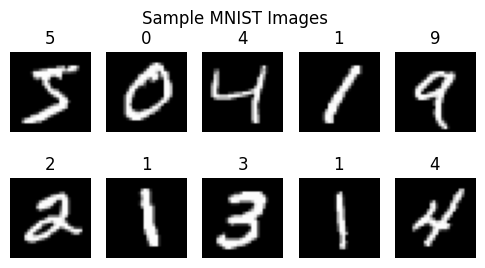

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
1688/1688 - 27s - 16ms/step - accuracy: 0.8011 - loss: 0.6405 - val_accuracy: 0.9443 - val_loss: 0.1712
Epoch 2/5
1688/1688 - 40s - 24ms/step - accuracy: 0.9490 - loss: 0.1622 - val_accuracy: 0.9532 - val_loss: 0.1493
Epoch 3/5
1688/1688 - 41s - 25ms/step - accuracy: 0.9654 - loss: 0.1098 - val_accuracy: 0.9725 - val_loss: 0.0939
Epoch 4/5
1688/1688 - 24s - 14ms/step - accuracy: 0.9727 - loss: 0.0863 - val_accuracy: 0.9823 - val_loss: 0.0656
Epoch 5/5
1688/1688 - 24s - 14ms/step - accuracy: 0.9773 - loss: 0.0724 - val_accuracy: 0.9815 - val_loss: 0.0667


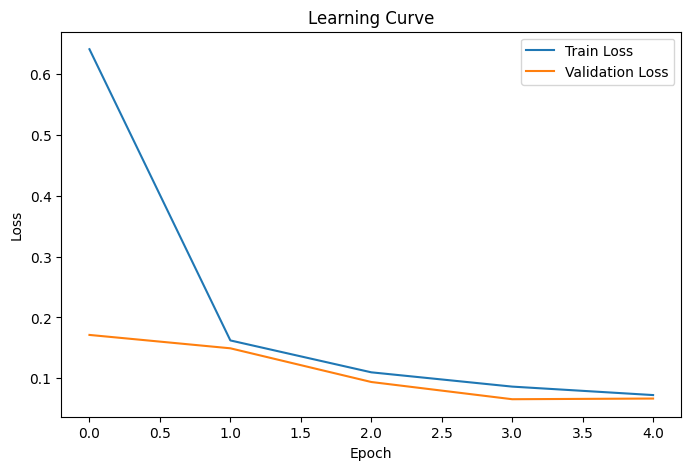

Test Accuracy: 0.9768


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import SGD

# Load & Preprocess MNIST

(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalize images to 0-1
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Reshape
x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

# One-hot encode labels
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

# Display some sample MNIST images
plt.figure(figsize=(6, 3))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(x_train[i].reshape(28,28), cmap='gray')
    plt.title(np.argmax(y_train[i]))
    plt.axis('off')
plt.suptitle("Sample MNIST Images")
plt.show()

# Scratch Fully Connected Layer

class FullyConnectedLayer:
    def __init__(self, input_size, output_size):
        self.W = np.random.randn(input_size, output_size) * 0.01
        self.b = np.zeros((1, output_size))

    def forward(self, x):
        self.x = x
        return np.dot(x, self.W) + self.b

    def backward(self, grad_output, learning_rate=0.01):
        grad_input = np.dot(grad_output, self.W.T)
        grad_W = np.dot(self.x.T, grad_output)
        grad_b = np.sum(grad_output, axis=0, keepdims=True)
        # Update weights
        self.W -= learning_rate * grad_W
        self.b -= learning_rate * grad_b
        return grad_input

# Activation functions
def relu(x):
    return np.maximum(0, x)

def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)

# LeNet-like CNN

lenet_model = Sequential([
    Conv2D(6, kernel_size=(5,5), activation='relu', input_shape=(28,28,1)),
    MaxPooling2D(pool_size=(2,2)),
    Conv2D(16, kernel_size=(5,5), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Flatten(),
    Dense(120, activation='relu'),
    Dense(84, activation='relu'),
    Dense(10, activation='softmax')
])

# Compile model
lenet_model.compile(optimizer=SGD(learning_rate=0.01),
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

# Training with mini-batches

history = lenet_model.fit(x_train, y_train,
                          batch_size=32,
                          epochs=5,
                          validation_split=0.1,
                          verbose=2)

# Plot Learning Curve (Extra)

plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.legend()
plt.show()

# Evaluate accuracy on test set

test_loss, test_acc = lenet_model.evaluate(x_test, y_test, verbose=0)
print(f"Test Accuracy: {test_acc:.4f}")
